In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# hyperparameters
batch_size = 32
block_size = 8
n_emb = 64
n_head = 8
head_size = n_emb / n_head
dropout = 0.2
n_layer = 3

max_iters = 3000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
eval_iters = 200
torch.manual_seed(1337)

cuda


In [2]:
# load data from input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[ch] for ch in s]
decode = lambda l: ''.join([itos[i] for i in l])
vocab_size = len(itos)

# split data to train and validation
data = torch.tensor(encode(text), dtype=torch.long)
n = int(len(data) * 0.9)
train_data = data[:n]
valid_data = data[n:]

# data loading
def batch_generate(split):
    data = train_data if split == 'train' else valid_data
    ix = torch.randint(0, len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i + block_size] for i in ix])
    y = torch.stack([data[i + 1:i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [3]:
@torch.no_grad()
def estimate_loss():
    out = {}
    for mode in ['train', 'val']:
        eval_loss = torch.zeros(eval_iters)
        for i in range(eval_iters):
            x, y = batch_generate(mode)
            logits, loss = model(x, y)
            eval_loss[i] = loss
        out[mode] = eval_loss.mean()
    return out

In [4]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(n_emb, head_size, bias=False)
        self.key = nn.Linear(n_emb, head_size, bias=False)
        self.value = nn.Linear(n_emb, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        q = self.query(x)
        k = self.key(x)
        att = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5
        att = att.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        v = self.value(x)
        out = att @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, head_size, n_head):
        super().__init__()
        self.multi_head = nn.ModuleList([Head(head_size) for _ in range(n_head)])
        self.proj = nn.Linear(n_head * head_size, n_emb)
        self.drop = nn.Dropout(dropout)
   
    def forward(self, x):
        x = torch.cat([h(x) for h in self.multi_head], dim=-1)
        x = self.drop(self.proj(x))
        return x

class FeedForward(nn.Module):
    def __init__(self, n_emb):
        super().__init__()
        self.ffwd = nn.Sequential(
            nn.Linear(n_emb, 4 * n_emb),
            nn.ReLU(),
            nn.Linear(4 * n_emb, n_emb),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.ffwd(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.ln_pre = nn.LayerNorm(n_embd)
        self.ln_past = nn.LayerNorm(n_embd)
        self.multi = MultiHeadAttention(head_size, n_head)
        self.ff = FeedForward(n_embd)

    def forward(self, x):
        x = x + self.multi(self.ln_pre(x))
        x = x + self.ff(self.ln_past(x))
        return x

In [5]:
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, n_emb)
        self.position_embedding = nn.Embedding(block_size, n_emb)
        self.lm_head = nn.Linear(n_emb, vocab_size)
        self.ln_f = nn.LayerNorm(n_emb)
        self.net = nn.Sequential(*[Block(n_emb, n_head=n_head) for _ in range(n_layer)])

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.emb(idx)
        pos_emb = self.position_embedding(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.net(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss

    def generate(self, context, max_tokens):
        for _ in range(max_tokens):
            context_crop = context[:, -block_size:]
            logits, _ = self(context_crop)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            context = torch.cat((context, next_token), dim=1)
        return context

Step 0: Train Loss = 4.2857, Val Loss = 4.2846
Step 300: Train Loss = 2.4264, Val Loss = 2.4305
Step 600: Train Loss = 2.2891, Val Loss = 2.2960
Step 900: Train Loss = 2.2177, Val Loss = 2.2473
Step 1200: Train Loss = 2.1804, Val Loss = 2.1987
Step 1500: Train Loss = 2.1387, Val Loss = 2.1740
Step 1800: Train Loss = 2.1119, Val Loss = 2.1523
Step 2100: Train Loss = 2.0909, Val Loss = 2.1452
Step 2400: Train Loss = 2.0749, Val Loss = 2.1340
Step 2700: Train Loss = 2.0535, Val Loss = 2.1276

---my mosve juied,
With my cingman, noteld thim svi'd titurace say
Hervie Lave, mor canrour thou has.'' for lord stoure such of thoot of thy comes out and with ust thane You net rute: but en, cawfs lord, a quid of as weose'd whoth is my therear you do sury stany to bothiin thavour dotwas if epeld ascofy thy shour, thatNuh hapqreTuD, dicks to Van lood.

FRA
CALAUKE
LOD:
Eave,
Why,
Ands porrosom drokene:
It thee wange acoring you to paty to for stands bid to have mair and hear,
Fichass
Go diand by


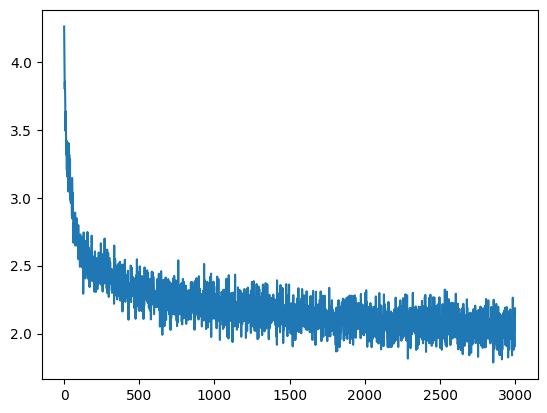

In [6]:
model = BigramLanguageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

losses = []
for iter in range(max_iters):
    if iter % eval_interval == 0:
        loss_dict = estimate_loss()
        print(f'Step {iter}: Train Loss = {loss_dict["train"]:.4f}, Val Loss = {loss_dict["val"]:.4f}')

    x, y = batch_generate('train')
    
    logits, loss = model(x, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_text = decode(model.generate(context, max_tokens=500)[0].tolist())
print(generated_text)

plt.plot(losses)
plt.savefig('loss.png')